# OBJETIVO
* Análise exploratória dos dados com os seguintes fins:
    * Identificação das localidades onde cada modelo tem os maiores preços
    * Verificação da quilometragem ótima de venda

# Carregamento de pacotes

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings

# Configuração do notebook

In [2]:
warnings.filterwarnings('ignore')

# Funções

In [3]:
# Função para montagem do histograma
def plot_histogram(data, model, info, bins):
    x = data[data['Modelo'] == model][info]
    print(f'Mínimo: {x.min()}')
    print(f'Máximo: {x.max()}')

    n, bins, patches = plt.hist(x, bins=bins)
    plt.rc('axes', axisbelow=True)
    plt.grid(axis='y')
    plt.xlabel('Valor')
    plt.ylabel('Frequência')
    plt.title(f'Histograma {model} - {info}')

# Calcula o preço relativo
def relative_price(price, base):
    return (price/base-1)*100

# Carregamento da base de dados

In [4]:
df_full = pd.read_csv('base_tratada.csv')
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92291 entries, 0 to 92290
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           92291 non-null  int64  
 1   Marca                92291 non-null  object 
 2   Modelo               92291 non-null  object 
 3   AnoModelo            92291 non-null  int64  
 4   AnoFabricacao        92291 non-null  int64  
 5   Quilometragem        92291 non-null  int64  
 6   PrecoAnuncio         92291 non-null  float64
 7   TipoAnuncio          92291 non-null  object 
 8   Cidade               92291 non-null  object 
 9   Estado               92291 non-null  object 
 10  Pais                 92291 non-null  object 
 11  MarketPlace          86080 non-null  object 
 12  Vendedor             92291 non-null  object 
 13  vendedorMarketplace  92291 non-null  object 
 14  Descricao            92291 non-null  object 
 15  VolumeMotor          92291 non-null 

In [5]:
df_full.drop('Unnamed: 0', axis=1, inplace=True)

# Coleta de amostra da base de dados

In [6]:
df = df_full
# df = df_full.head(10)
# df = df_full.sample(50)

df.head()

,Marca,Modelo,AnoModelo,AnoFabricacao,Quilometragem,PrecoAnuncio,TipoAnuncio,Cidade,Estado,Pais,MarketPlace,Vendedor,vendedorMarketplace,Descricao,VolumeMotor,Trasmissao,Combustivel
0,KIA,SPORTAGE,2020,2019,1628,171480.0,PJ,SAO PAULO,SP,BR,NaN,LOCALIZA,Localiza,EX 2.0 FLEX 4P C/AR - AUTOMATICO,2.0,AUTOMATICO BOM,OUTRO
1,FORD,ECOSPORT,2020,2019,5940,81450.0,PJ,SAO PAULO,SP,BR,NaN,LOCALIZA,Localiza,SE 1.5 12V FLEX 4P C/AR - AUTOMATICO,1.5,AUTOMATICO BOM,OUTRO
2,FORD,ECOSPORT,2020,2019,6830,81070.0,PJ,OSASCO,SP,BR,NaN,LOCALIZA,Localiza,SE 1.5 12V FLEX 4P C/AR - AUTOMATICO,1.5,AUTOMATICO BOM,OUTRO
3,BMW,X4,2017,2016,7454,295910.0,PJ,SAO PAULO,SP,BR,NaN,LOCALIZA,Localiza,XDRIVE 35I M SPORT 3.0 4P C/AR - AUTOMATICO BL...,3.0,AUTOMATICO BOM,OUTRO
4,JEEP,RENEGADE,2019,2019,7496,94060.0,PJ,NITEROI,RJ,BR,NaN,LOCALIZA,Localiza,LONGITUDE 1.8 16V FLEX 4P C/AR - AUTOMATICO,1.8,AUTOMATICO BOM,OUTRO


# Análise dos dados com base no modelo

In [7]:
models = np.sort(df['Modelo'].unique())

print('MODELOS')
print(models)

MODELOS
['2008' '207' '208' '220I' '3008' '308' '308CC' '320I' '408' '5008' '508'
 '535I' '540I' 'A3 SEDAN' 'A4 HATCH' 'A4 SEDAN' 'AMAROK' 'ARGO' 'ARRIZO 6'
 'BOXER' 'C 180' 'C 250' 'C 300' 'C4' 'C4 CACTUS' 'C4 GRAND PICASSO'
 'C4 LOUNGE' 'CAMRY' 'CAPTUR' 'CARNIVAL' 'CITY' 'CIVIC' 'CLA 180'
 'CLASSE C' 'COBALT' 'COMPASS' 'COROLLA' 'CRETA' 'CRONOS' 'CRUZE HATCH'
 'CRUZE SEDAN' 'DISCOVERY SPORT' 'DOBLO' 'DUCATO' 'DUSTER' 'DUSTER OROCH'
 'E 250' 'E 63 AMG' 'E-PACE' 'ECOSPORT' 'EDGE' 'EQUINOX' 'ETIOS HATCH'
 'ETIOS SEDAN' 'EXPERT' 'FIESTA' 'FIORINO' 'FIT' 'FLUENCE' 'FOCUS HATCH'
 'FOCUS SEDAN' 'FORESTER' 'FOX' 'FRONTIER' 'FUSION' 'GLA 200' 'GLA 250'
 'GLC 250' 'GOL' 'GRAND SIENA' 'HB20' 'HB20S' 'HILUX' 'HOGGAR' 'HR-V'
 'IDEA' 'IX35' 'JETTA' 'JUMPY' 'KA HATCH' 'KA SEDAN' 'KANGOO' 'KICKS'
 'KWID' 'L200 TRITON' 'LANCER' 'LEAF' 'LOGAN' 'MARCH' 'MASTER' 'MOBI'
 'MONTANA' 'NIVUS' 'ONIX' 'OUTLANDER' 'PAJERO FULL' 'PALIO' 'PARTNER'
 'PASSAT' 'POLO' 'PRISMA' 'PRIUS' 'Q3' 'Q5' 'RANGE ROVER EVOQUE'
 

In [8]:
#Escolha do modelo a ser analisado
model = 'FOCUS SEDAN'

Mínimo: 2017
Máximo: 2019


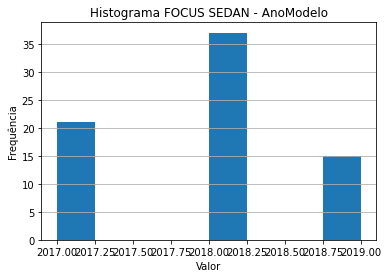

In [9]:
plot_histogram(df , model, 'AnoModelo', 'auto')

Mínimo: 100
Máximo: 117000


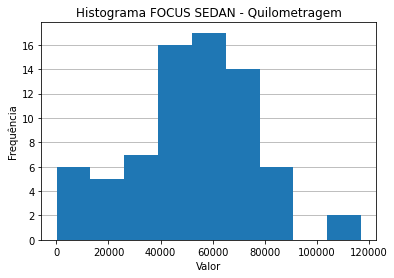

In [10]:
plot_histogram(df, model, 'Quilometragem', 'auto')

## Observações feitas
* A distribuição do AnoModelo não precisa de corte
* Intervalo de análise entre 30.000 e 80.000 km
* A data tem o mesmo valor em todas as entradas

In [11]:
# Filtragem escolhida
df_filtered = df[(df['Modelo'] == model) &
                 (df['Quilometragem'].between(30000, 80000))]


Mínimo: 30400
Máximo: 80000


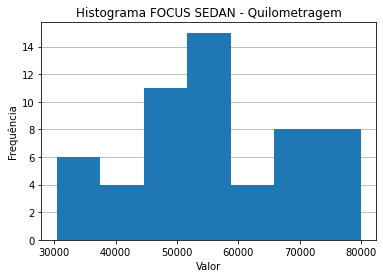

In [12]:
plot_histogram(df_filtered, model, 'Quilometragem', 'auto')

# Identificação das localidades onde cada modelo tem os maiores preços

## Colunas de interesse:
* Modelo
* AnoModelo
* Quilometragem

In [13]:
# Descrições do modelo escolhido
print(df[df['Modelo'] == model]['Descricao'].unique())

['FASTBACK SE 2.0 16V DIRECT FLEX 4P C/AR - AUTOMATICO'
 '2.0 SE FASTBACK 16V FLEX 4P POWERSHIFT'
 '2.0 TITANIUM PLUS FASTBACK 16V FLEX 4P POWERSHIFT']


In [14]:
base_state = 'RJ'

# Filtra por modelo e calcula o preço médio por estado
df_plot = df_filtered[df['Modelo'] == model][['Estado', 'PrecoAnuncio']].groupby(['Estado'], as_index = True).mean()

#Cria coluna de preço relativo
col_relative_price = 'PrecoRelativo'
df_plot[col_relative_price] = ''

# Encontra o preço base conforme o estado escolhido
base_price = df_plot.at[base_state, 'PrecoAnuncio']

for index, row in df_plot.iterrows():
    df_plot[col_relative_price][index] = relative_price(df_plot.at[index, 'PrecoAnuncio'], base_price)

df_plot.sort_values(by = 'PrecoRelativo', inplace=True)

print(f'Estado base: {base_state}')
print(f'Modelo: {model}')
df_plot

Estado base: RJ
Modelo: FOCUS SEDAN


,PrecoAnuncio,PrecoRelativo
Estado,,
MT,58799.000000,-1.897023
RJ,59936.000000,0.0
SP,62797.500000,4.774259
RS,65322.500000,8.987086
ES,66330.000000,10.668046
BA,66900.000000,11.61906
PR,67665.750000,12.896673
SC,71286.333333,18.937422


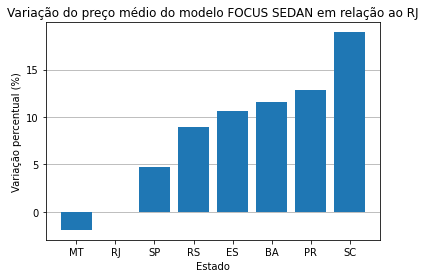

In [15]:
x = df_plot.index
y = df_plot['PrecoRelativo']
title = f'Variação do preço médio do modelo {model} em relação ao {base_state}'
x_label = 'Estado'
y_label = 'Variação percentual (%)'

plt.rc('axes', axisbelow=True)
plt.grid(axis='y')
plt.bar(x,y)
plt.title(title)
plt.xlabel(x_label)
plt.ylabel(y_label)

plt.show()

# Avaliação da relação entre quilometragem e preço de venda